In [39]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2
# !pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin

In [40]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [42]:
## loading PneumoniaMNIST dataset

#data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

#NUM_EPOCHS = 3
BATCH_SIZE = 64
#lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [43]:
# transformer definitions -- go here
# default transformer


## transfomer to experiment --  
# the below is data --augmentation -- transformer
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# load the data
train_dataset = DataClass(split='train', transform=transform_train, download=download)
test_dataset = DataClass(split='test', transform=transform_test, download=download)
val_dataset = DataClass(split='val', transform=transform_val, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)



Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [44]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1'

In [45]:
from torchvision.models import Weights
# instantiate the ResNet-50 model and set it to training mode
# model = ResNet50() --> yielded  low AUC and ACC on train and test data.
# instantiate the ResNet-18 model[Single Channel] and set it to training mode --
# added dropout and batch normalization as regularization methods.
import torchvision
model = torchvision.models.resnet18()
# model = model.cuda()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)



from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 100
decay_epochs = [25, 50, 75]

# Set new hyperparameters
lr = 0.1  # Lower learning rate
weight_decay = 0.01  # Decrease weight decay
margin = 1.0
loss_fn = AUCMLoss()

# Set optimizer with new hyperparameters
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 momentum=0.8,
                 margin=margin,
                 epoch_deacy = 0.03,
                 lr=lr)


In [46]:
from sklearn.metrics import roc_auc_score

from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score


print('Start Training')
print('-' * 30)

train_log = []
val_log = []
test_log = []
best_val_auc = 0
patience = 15
num_epochs_without_improvement = 0
for epoch in range(total_epochs):

    train_loss = []
    model.train()
    for data, targets in tqdm(train_loader):
        y_pred = model(data)
        loss = loss_fn(y_pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # evaluation on train, validation, and test sets
    model.eval()
    train_pred_list = []
    train_true_list = []
    for train_data, train_targets in train_loader_at_eval:
        train_pred = model(train_data)
        train_pred_list.append(train_pred.cpu().detach().numpy())
        train_true_list.append(train_targets.numpy())
    train_true = np.concatenate(train_true_list)
    train_pred = np.concatenate(train_pred_list)
    train_auc = auc_roc_score(train_true, train_pred)
    train_loss = np.mean(train_loss)

    val_pred_list = []
    val_true_list = []
    for val_data, val_targets in val_loader:
        val_pred = model(val_data)
        val_pred_list.append(val_pred.cpu().detach().numpy())
        val_true_list.append(val_targets.numpy())
    val_true = np.concatenate(val_true_list)
    val_pred = np.concatenate(val_pred_list)
    val_auc = auc_roc_score(val_true, val_pred)

    test_pred_list = []
    test_true_list = []
    for test_data, test_targets in test_loader:
        test_pred = model(test_data)
        test_pred_list.append(test_pred.cpu().detach().numpy())
        test_true_list.append(test_targets.numpy())
    test_true = np.concatenate(test_true_list)
    test_pred = np.concatenate(test_pred_list)
    test_auc = auc_roc_score(test_true, test_pred)
    model.train()

    # print results
    print("epoch: %s, train_loss: %.4f, train_auc: %.4f, val_auc: %.4f, test_auc: %.4f, lr: %.4f" % (
        epoch, train_loss, train_auc[0], val_auc[0], test_auc[0], optimizer.lr))
    train_log.append(train_auc[0])
    val_log.append(val_auc[0])
    test_log.append(test_auc[0])

    # check for improvement in validation AUC and update early stopping counter
    if val_auc[0] > best_val_auc:
        best_val_auc = val_auc[0]
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1

    # check if early stopping criteria is met
    if num_epochs_without_improvement >= patience:
        print(f'No improvement for {patience} epochs. Stopping early.')
        break


Start Training
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


epoch: 0, train_loss: 31.8950, train_auc: 0.5911, val_auc: 0.6007, test_auc: 0.5750, lr: 0.1000


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


epoch: 1, train_loss: 2.6969, train_auc: 0.3902, val_auc: 0.4094, test_auc: 0.3975, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 2, train_loss: 0.1751, train_auc: 0.5176, val_auc: 0.5998, test_auc: 0.5326, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 3, train_loss: 0.1747, train_auc: 0.6397, val_auc: 0.6583, test_auc: 0.6124, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


epoch: 4, train_loss: 0.1823, train_auc: 0.7316, val_auc: 0.7210, test_auc: 0.6790, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 5, train_loss: 0.1610, train_auc: 0.7600, val_auc: 0.7552, test_auc: 0.7128, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 6, train_loss: 0.1459, train_auc: 0.7806, val_auc: 0.7803, test_auc: 0.7408, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 7, train_loss: 0.1510, train_auc: 0.7861, val_auc: 0.7711, test_auc: 0.7592, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 8, train_loss: 0.1338, train_auc: 0.7233, val_auc: 0.7193, test_auc: 0.6995, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 9, train_loss: 0.1278, train_auc: 0.8191, val_auc: 0.8137, test_auc: 0.7895, lr: 0.1000


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


epoch: 10, train_loss: 0.1308, train_auc: 0.8254, val_auc: 0.8020, test_auc: 0.7916, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 11, train_loss: 0.1113, train_auc: 0.8433, val_auc: 0.7978, test_auc: 0.8254, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 12, train_loss: 0.1060, train_auc: 0.8492, val_auc: 0.8287, test_auc: 0.8271, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 13, train_loss: 0.0946, train_auc: 0.8621, val_auc: 0.8079, test_auc: 0.8363, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 14, train_loss: 0.0853, train_auc: 0.8743, val_auc: 0.8179, test_auc: 0.8312, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 15, train_loss: 0.0792, train_auc: 0.8998, val_auc: 0.8388, test_auc: 0.8707, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 16, train_loss: 0.0929, train_auc: 0.8811, val_auc: 0.8354, test_auc: 0.8442, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 17, train_loss: 0.1249, train_auc: 0.8301, val_auc: 0.7836, test_auc: 0.7953, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


epoch: 18, train_loss: 0.1183, train_auc: 0.8246, val_auc: 0.7878, test_auc: 0.7838, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


epoch: 19, train_loss: 0.0834, train_auc: 0.9171, val_auc: 0.8705, test_auc: 0.8619, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 20, train_loss: 0.0715, train_auc: 0.9200, val_auc: 0.8571, test_auc: 0.8571, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 21, train_loss: 0.0794, train_auc: 0.9193, val_auc: 0.8404, test_auc: 0.8693, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 22, train_loss: 0.0836, train_auc: 0.9342, val_auc: 0.8805, test_auc: 0.8619, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 23, train_loss: 0.0749, train_auc: 0.9372, val_auc: 0.8663, test_auc: 0.8755, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


epoch: 24, train_loss: 0.0815, train_auc: 0.9147, val_auc: 0.8521, test_auc: 0.8452, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 25, train_loss: 0.0669, train_auc: 0.9410, val_auc: 0.8755, test_auc: 0.8751, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 26, train_loss: 0.0650, train_auc: 0.8975, val_auc: 0.8237, test_auc: 0.8281, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


epoch: 27, train_loss: 0.0680, train_auc: 0.9279, val_auc: 0.8379, test_auc: 0.8784, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 28, train_loss: 0.0586, train_auc: 0.9588, val_auc: 0.8663, test_auc: 0.8966, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 29, train_loss: 0.0482, train_auc: 0.9671, val_auc: 0.8855, test_auc: 0.8979, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 30, train_loss: 0.0466, train_auc: 0.9627, val_auc: 0.8797, test_auc: 0.8887, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 31, train_loss: 0.0490, train_auc: 0.9736, val_auc: 0.8755, test_auc: 0.8868, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 32, train_loss: 0.0525, train_auc: 0.9638, val_auc: 0.8747, test_auc: 0.8711, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 33, train_loss: 0.0573, train_auc: 0.8991, val_auc: 0.8212, test_auc: 0.7937, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 34, train_loss: 0.0576, train_auc: 0.9623, val_auc: 0.8697, test_auc: 0.8448, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 35, train_loss: 0.0396, train_auc: 0.9801, val_auc: 0.8764, test_auc: 0.8820, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 36, train_loss: 0.0404, train_auc: 0.9690, val_auc: 0.8722, test_auc: 0.9010, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


epoch: 37, train_loss: 0.0475, train_auc: 0.9849, val_auc: 0.8847, test_auc: 0.8864, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 38, train_loss: 0.0361, train_auc: 0.9882, val_auc: 0.8764, test_auc: 0.8701, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 39, train_loss: 0.0419, train_auc: 0.9866, val_auc: 0.8722, test_auc: 0.8828, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 40, train_loss: 0.0325, train_auc: 0.9774, val_auc: 0.8429, test_auc: 0.8906, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 41, train_loss: 0.0520, train_auc: 0.9897, val_auc: 0.8947, test_auc: 0.8935, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


epoch: 42, train_loss: 0.0377, train_auc: 0.9310, val_auc: 0.8555, test_auc: 0.8114, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 43, train_loss: 0.0373, train_auc: 0.9752, val_auc: 0.8889, test_auc: 0.8983, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 44, train_loss: 0.0424, train_auc: 0.9890, val_auc: 0.8830, test_auc: 0.8588, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 45, train_loss: 0.0429, train_auc: 0.9878, val_auc: 0.8822, test_auc: 0.8695, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 46, train_loss: 0.0249, train_auc: 0.9939, val_auc: 0.8780, test_auc: 0.8615, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 47, train_loss: 0.0405, train_auc: 0.9938, val_auc: 0.8964, test_auc: 0.8801, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 48, train_loss: 0.0277, train_auc: 0.9941, val_auc: 0.8864, test_auc: 0.8860, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 49, train_loss: 0.0273, train_auc: 0.8928, val_auc: 0.8179, test_auc: 0.7636, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 50, train_loss: 0.0306, train_auc: 0.9967, val_auc: 0.9048, test_auc: 0.8814, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 51, train_loss: 0.0154, train_auc: 0.9975, val_auc: 0.9064, test_auc: 0.8743, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 52, train_loss: 0.0340, train_auc: 0.9934, val_auc: 0.8705, test_auc: 0.8477, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 53, train_loss: 0.0175, train_auc: 0.9987, val_auc: 0.8822, test_auc: 0.8732, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 54, train_loss: 0.0184, train_auc: 0.9983, val_auc: 0.8889, test_auc: 0.8678, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 55, train_loss: 0.0281, train_auc: 0.9137, val_auc: 0.8062, test_auc: 0.7911, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 56, train_loss: 0.0418, train_auc: 0.9960, val_auc: 0.8713, test_auc: 0.8613, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


epoch: 57, train_loss: 0.0146, train_auc: 0.9992, val_auc: 0.8780, test_auc: 0.8878, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


epoch: 58, train_loss: 0.0142, train_auc: 0.9969, val_auc: 0.8939, test_auc: 0.8699, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 59, train_loss: 0.0165, train_auc: 0.9924, val_auc: 0.8538, test_auc: 0.8628, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 60, train_loss: 0.0174, train_auc: 0.9432, val_auc: 0.8488, test_auc: 0.8085, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


epoch: 61, train_loss: 0.0217, train_auc: 0.9988, val_auc: 0.8780, test_auc: 0.8764, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 62, train_loss: 0.0207, train_auc: 0.9990, val_auc: 0.8914, test_auc: 0.8943, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 63, train_loss: 0.0208, train_auc: 0.9993, val_auc: 0.8889, test_auc: 0.8705, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 64, train_loss: 0.0229, train_auc: 0.9745, val_auc: 0.8287, test_auc: 0.8574, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


epoch: 65, train_loss: 0.0420, train_auc: 0.9991, val_auc: 0.8997, test_auc: 0.8904, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 66, train_loss: 0.0112, train_auc: 0.9994, val_auc: 0.8997, test_auc: 0.8947, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 67, train_loss: 0.0142, train_auc: 0.9995, val_auc: 0.8956, test_auc: 0.8789, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 68, train_loss: 0.0137, train_auc: 0.9991, val_auc: 0.8864, test_auc: 0.8655, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 69, train_loss: 0.0108, train_auc: 0.9997, val_auc: 0.8939, test_auc: 0.8605, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 70, train_loss: 0.0184, train_auc: 0.9999, val_auc: 0.9081, test_auc: 0.8816, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 71, train_loss: 0.0132, train_auc: 1.0000, val_auc: 0.9089, test_auc: 0.8956, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


epoch: 72, train_loss: 0.0082, train_auc: 1.0000, val_auc: 0.9014, test_auc: 0.9023, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 73, train_loss: 0.0126, train_auc: 0.9999, val_auc: 0.8931, test_auc: 0.8901, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 74, train_loss: 0.0165, train_auc: 0.9998, val_auc: 0.8772, test_auc: 0.8590, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


epoch: 75, train_loss: 0.0106, train_auc: 0.9329, val_auc: 0.7360, test_auc: 0.8206, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 76, train_loss: 0.0388, train_auc: 0.9995, val_auc: 0.8839, test_auc: 0.8837, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 77, train_loss: 0.0098, train_auc: 0.9999, val_auc: 0.8989, test_auc: 0.8876, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 78, train_loss: 0.0095, train_auc: 1.0000, val_auc: 0.9098, test_auc: 0.8960, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 79, train_loss: 0.0103, train_auc: 1.0000, val_auc: 0.8989, test_auc: 0.8876, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 80, train_loss: 0.0091, train_auc: 1.0000, val_auc: 0.8847, test_auc: 0.8954, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 81, train_loss: 0.0053, train_auc: 1.0000, val_auc: 0.9064, test_auc: 0.8718, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


epoch: 82, train_loss: 0.0065, train_auc: 0.9996, val_auc: 0.8914, test_auc: 0.8402, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 83, train_loss: 0.0076, train_auc: 1.0000, val_auc: 0.9031, test_auc: 0.8832, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 84, train_loss: 0.0095, train_auc: 1.0000, val_auc: 0.8864, test_auc: 0.8818, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 85, train_loss: 0.0128, train_auc: 0.9963, val_auc: 0.8622, test_auc: 0.8624, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 86, train_loss: 0.0108, train_auc: 1.0000, val_auc: 0.8939, test_auc: 0.8655, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 87, train_loss: 0.0101, train_auc: 0.9991, val_auc: 0.8789, test_auc: 0.8246, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 88, train_loss: 0.0124, train_auc: 1.0000, val_auc: 0.8814, test_auc: 0.8511, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


epoch: 89, train_loss: 0.0054, train_auc: 0.9999, val_auc: 0.8663, test_auc: 0.8716, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 90, train_loss: 0.0042, train_auc: 1.0000, val_auc: 0.8697, test_auc: 0.8728, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


epoch: 91, train_loss: 0.0049, train_auc: 1.0000, val_auc: 0.8931, test_auc: 0.8678, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 92, train_loss: 0.0062, train_auc: 1.0000, val_auc: 0.8872, test_auc: 0.8674, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 93, train_loss: 0.0136, train_auc: 0.9886, val_auc: 0.8187, test_auc: 0.7521, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 94, train_loss: 0.0139, train_auc: 0.9984, val_auc: 0.8605, test_auc: 0.8177, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


epoch: 95, train_loss: 0.0101, train_auc: 1.0000, val_auc: 0.8872, test_auc: 0.8665, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 96, train_loss: 0.0039, train_auc: 1.0000, val_auc: 0.8805, test_auc: 0.8864, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


epoch: 97, train_loss: 0.0110, train_auc: 0.9999, val_auc: 0.8956, test_auc: 0.8582, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 98, train_loss: 0.0143, train_auc: 0.9996, val_auc: 0.8680, test_auc: 0.8676, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 99, train_loss: 0.0072, train_auc: 1.0000, val_auc: 0.8713, test_auc: 0.8839, lr: 0.1000


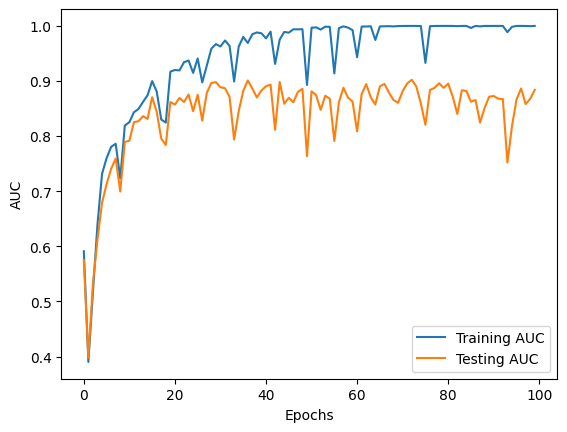

In [47]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [48]:
print("Final Train AUC:", train_log[-1])
print("Final Test AUC:", test_log[-1])


Final Train AUC: 1.0
Final Test AUC: 0.8838763575605681
